# Optimising almost-Clifford circuits

In this Notebook we will produce some comparisons for how the PyZX Clifford simplification procedure fares in comparison to more naive approaches.

First we import all the necessary libraries

In [2]:
import sys; sys.path.append('..')
import random, math, os
import pyzx as zx
from fractions import Fraction
from functools import reduce
import numpy as np
%config InlineBackend.figure_format = 'svg'

Now we define some useful functions for generating our data and optimizing circuits

In [3]:
def generate_clifford_circuit(qubits, depth, p_cnot=0.3, p_t=0):
    p_s = 0.5*(1.0-p_cnot-p_t)
    p_had = 0.5*(1.0-p_cnot-p_t)
    c = zx.Circuit(qubits)
    for _ in range(depth):
        r = random.random()
        if r > 1-p_had:
            c.add_gate("HAD",random.randrange(qubits))
        elif r > 1-p_had-p_s:
            c.add_gate("S",random.randrange(qubits))
        elif r > 1-p_had-p_s-p_t:
            c.add_gate("T",random.randrange(qubits))
        else:
            tgt = random.randrange(qubits)
            while True:
                ctrl = random.randrange(qubits)
                if ctrl!=tgt: break
            c.add_gate("CNOT",tgt,ctrl)
    return c

For the naive approach, we introduce a function that splits the circuit when a T gate is encountered and a function for merging circuits back together.

In [4]:
def split_circ_on_T(c):
    """Produces a list of circuits whose odd elements are T-free circuits and
    whose even elements are circuits consisting only of T gates. Note it expects
    the circuit to only have basic gates (i.e. at most 1 control)."""
    q = c.qubits
    
    # keep lists of T-free and T-only circuits
    cs0 = [zx.Circuit(q)]
    cs1 = [zx.Circuit(q)]
    after = zx.Circuit(q)
    blocked = set()
    blocked2 = set()
    for g in c.gates:
        if g.name == 'T':
            if g.target in blocked2:
                cs0.append(after)
                after = zx.Circuit(q)
                cs1.append(zx.Circuit(q))
                blocked.clear()
                blocked2.clear()
                cs1[-1].gates.append(g)
                blocked.add(g.target)
            else:
                cs1[-1].gates.append(g)
                blocked.add(g.target)
        else:
            if g.name in ('CNOT','HAD') and g.target in blocked: 
                after.gates.append(g)
                blocked2.add(g.target)
                if g.name == 'CNOT': 
                    blocked.add(g.control)
            elif g.target in blocked2 or (g.name == 'CNOT' and g.control in blocked2):
                after.gates.append(g)
                if g.name == 'CNOT': 
                    blocked.add(g.target)
                    blocked2.add(g.target)
            else:
                cs0[-1].gates.append(g)
    cs = []
    for i,c0 in enumerate(cs0):
        cs.append(c0)
        cs.append(cs1[i])
    cs.append(after)
    return cs
def merge_circ(cs):
    c0 = zx.Circuit(cs[0].qubits)
    for c in cs:
        c0.add_circuit(c)
    return c0

Testing circuit generation and split/merge code.

In [5]:
c = generate_clifford_circuit(6,100,p_t=0.1)
zx.d3.draw(c)

In [6]:
cs = split_circ_on_T(c)
print(len(cs))
#zx.d3.draw(cs[4])
c2 = merge_circ(cs)
print(zx.compare_tensors(c,c2))
g = c2.to_graph(False)
zx.d3.draw(g)

7
True


In [7]:
def opt_circuit(c):
    g = c.to_graph()
    zx.simplify.interior_clifford_simp(g,quiet=True)
    c2 = zx.extract.streaming_extract(g)
    return zx.optimize.basic_optimization(c2.to_basic_gates()).to_basic_gates()
def part_opt_circuit(c):
    cs = split_circ_on_T(c)
    for i in range(len(cs)):
        if i % 2 == 0:
            cs[i] = opt_circuit(cs[i])
    return zx.optimize.basic_optimization(merge_circ(cs)).to_basic_gates()

In [8]:
def generate_dataset(qubits,depth,cnot_prob,t_prob,reps=50,two_q=False):
    """Generates a set of `reps` circuits consisting of `layers` amount of Clifford circuits,
    interspersed with T gates that appear with probability `t_prob` on every qubit.
    Each Clifford layer has `depth` amount of gates."""
    stats = []
    
    count = [0,0,0,0]
    count2 = [0,0,0,0]
    for _ in range(reps):
        c = generate_clifford_circuit(qubits,depth,p_cnot=cnot_prob,p_t=t_prob)
        c0 = c.copy()
        c0 = zx.optimize.basic_optimization(c0).to_basic_gates()
        c1 = part_opt_circuit(c)
        c2 = opt_circuit(c)
        
        count[0] += len(c.gates)
        count[1] += len(c0.gates)
        count[2] += len(c1.gates)
        count[3] += len(c2.gates)
        
        count2[0] += c.twoqubitcount()
        count2[1] += c0.twoqubitcount()
        count2[2] += c1.twoqubitcount()
        count2[3] += c2.twoqubitcount()
        

    for i in range(4):
        count[i] /= reps
        count2[i] /= reps
    
    return (count, count2)

Now we generate some data comparing the different optimization methods when we vary the gate count per Clifford block

In [13]:
random.seed(42)
xs = [0.015*i for i in range(11)]

yys = [[],[],[],[]]
zzs = [[],[],[],[]]
qubits = 8
reps = 20
for t_prob in xs:
    print(t_prob, end=';')
    depth = 800
    ys,zs = generate_dataset(qubits,depth,cnot_prob=0.3,t_prob=t_prob,reps=reps)
    for i,y in enumerate(ys): yys[i].append(y)
    for i,z in enumerate(zs): zzs[i].append(z)

0.0;0.015;0.03;0.045;0.06;0.075;0.09;0.105;0.12;0.135;0.15;

And now we plot the resulting data

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn-whitegrid')
colours = ['#53257f', '#bc1b73', '#f8534a', '#ffa600']
names = ['original','original+','naive', 'pyzx']
styles = ['-','--','-.',':']

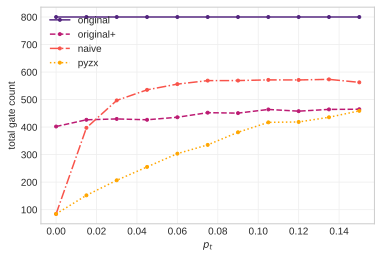

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for i, ys in enumerate(yys):
    ax1.plot(xs, ys, c=colours[i], marker="o",markersize=3, linestyle=styles[i], label=names[i])

ax1.set_ylabel("total gate count")
ax1.set_xlabel("$p_t$")
plt.legend(loc='upper left');
plt.grid(color='#EEEEEE')
plt.show()

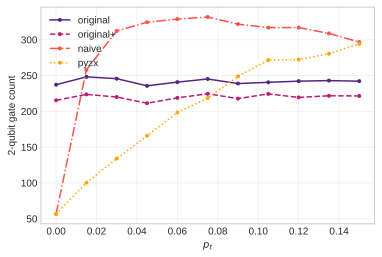

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for i, zs in enumerate(zzs):
    ax1.plot(xs, zs, c=colours[i], marker="o",markersize=3, linestyle=styles[i], label=names[i])

ax1.set_ylabel("2-qubit gate count")
ax1.set_xlabel("$p_t$")
plt.legend(loc='upper left');
plt.grid(color='#EEEEEE')
plt.show()

As can be seen, both of the extraction methods, the one that only acts on the block of Cliffords, and the full extraction, saturate in the amount of 2-qubit gates, but the full extraction saturates at a much lower total gate count, showing that it indeed performs better than naive Clifford optimization.

In [44]:
fig.savefig(r'/home/aleks/git/papers/cliff-simp/graphics/gatecount-2q.pdf',bbox_inches='tight')

As can be seen, as the amount of T gates between the layers increases, the full method starts performing more comparably to the block extraction method. This is to be expected as the T gates act as obstructions to our simplification method.